In [1]:
import pandas as pd

df = pd.read_csv('Data/data.csv')
df.head()

C:\Users\ryana\AppData\Local\Temp\ipykernel_13084\2155276850.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/data.csv')


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


# Geospatial Plots

In [2]:
#filter the df to where anything that doesn't have a latitude and langitude are dropped

df_geo = df.dropna(subset=['LATITUDE', 'LONGITUDE'])
#Also remove any where latitude or longitude are 0
df_geo = df_geo[(df_geo['LATITUDE'] != 0) & (df_geo['LONGITUDE'] != 0)]

In [3]:
# This can get super cluttered super fast, so let's take a simple random sample of N=2000. This should be plenty to get a good idea of the entire dataset
# using random_state=42 for reproducibility
df_geo = df_geo.sample(n=2000, random_state=42)

In [4]:
import geopandas as gpd
import geodatasets as gds
import folium
from folium.plugins import MarkerCluster
from folium import Choropleth, Circle, Marker

gdf = gpd.read_file(gds.get_path("nybb"))
gdf = gdf.set_index("BoroName")
gdf['area'] = gdf.area

gdf.explore("area", legend=False)


# # Define NYC map center coordinates
nyc_coords = [40.7128, -74.0060]

# Create the map
nyc_crashes = folium.Map(location=nyc_coords, zoom_start=10)

# Add points to the map
for idx, row in df_geo.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(nyc_crashes)

nyc_crashes

Conclusion: This is super cluttered, but we're getting somewhere with this.

In [5]:
# Now, let's INSTEAD generate a heatmap of the data points
from folium.plugins import HeatMap

# Create the map

nyc_crashes_heatmap = folium.Map(location=nyc_coords, zoom_start=15)

# Add points to the map
heat_data = [[row['LATITUDE'], row['LONGITUDE']] for idx, row in df_geo.iterrows()]
HeatMap(heat_data).add_to(nyc_crashes_heatmap)

nyc_crashes_heatmap

Conclusion: This is much nicer! I would encourage you to look thru the map for perhaps a talking point or two.

### Let's get looking into some of the most dangerous STREETS in NYC. Let's see if it matches with the heatmap above.

In [6]:
# Luckily, that's an actual column in the dataset! Let's generate a list, then remake the heatmap with the dangerous streets highlighted

#Aggregate the data by street name -- but let's use the population not the sample, since it will be more accurate and easy to actually calculate

df_streets = df.dropna(subset=['ON STREET NAME', 'LATITUDE', 'LONGITUDE'])
df_streets = df_streets[(df_streets['LATITUDE'] != 0) & (df_streets['LONGITUDE'] != 0)]
df_streets = df_geo.groupby('ON STREET NAME').size().reset_index(name='counts')
df_streets = df_streets.sort_values(by='counts', ascending=False)

df_tmp = df[['ON STREET NAME', 'LATITUDE', 'LONGITUDE']]

# Get the first coords per street
df_tmp = df_tmp.dropna(subset=['LATITUDE', 'LONGITUDE'])
df_tmp = df_tmp[(df_tmp['LATITUDE'] != 0) & (df_tmp['LONGITUDE'] != 0)]
df_tmp = df_tmp.groupby('ON STREET NAME').first().reset_index()

print("Most dangerous streets in NYC:")
print(df_streets.head(n=25))

Most dangerous streets in NYC:
                       ON STREET NAME  counts
252  BELT PARKWAY                          24
272  BROADWAY                              19
676  NORTHERN BOULEVARD                    18
209  ATLANTIC AVENUE                       15
610  LONG ISLAND EXPRESSWAY                14
128  5 AVENUE                              11
0    1 AVENUE                              10
487  FLATBUSH AVENUE                       10
95   3 AVENUE                               9
196  AMSTERDAM AVENUE                       9
678  NOSTRAND AVENUE                        8
570  JAMAICA AVENUE                         8
72   2 AVENUE                               8
674  NORTH CONDUIT AVENUE                   8
622  MAJOR DEEGAN EXPRESSWAY                8
296  CANAL STREET                           8
247  BEDFORD AVENUE                         8
288  BRUCKNER BOULEVARD                     8
681  OCEAN AVENUE                           7
524  GRAND CENTRAL PKWY                     7
153

In [7]:
#Now, let's remake the heatmap but mark with red the 25 most dangerous streets

# Create the map
nyc_crashes_heatmap = folium.Map(location=nyc_coords, zoom_start=15)

# Add points to the map
heat_data = [[row['LATITUDE'], row['LONGITUDE']] for idx, row in df_geo.iterrows()]
HeatMap(heat_data).add_to(nyc_crashes_heatmap)

# Add the 25 most dangerous streets
for idx, row in df_streets[:25].iterrows():
    street_name = row['ON STREET NAME']
    # Get the FIRST coords per street -- this is just an estimate for where the street is. Better than using a mean
    # because we want to specifically but the marker on the actual street!
    coords = df_tmp[df_tmp['ON STREET NAME'] == street_name].iloc[0]
    Marker([coords['LATITUDE'], coords['LONGITUDE']], popup=street_name, icon=folium.Icon(color='red')).add_to(nyc_crashes_heatmap)

nyc_crashes_heatmap

Conclusion: Looks like the markers match relatively with the heatmap above. This is a good sign that the data is consistent.

# Crashes by Date

In [8]:
#Make sure CRASH DATE is a datetime

df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], format='%m/%d/%Y', errors='coerce')
#Filter out any rows that don't have a crash date
df_dates = df.dropna(subset=['CRASH DATE'])
df_dates.dtypes

CRASH DATE                       datetime64[ns]
CRASH TIME                               object
BOROUGH                                  object
ZIP CODE                                 object
LATITUDE                                float64
LONGITUDE                               float64
LOCATION                                 object
ON STREET NAME                           object
CROSS STREET NAME                        object
OFF STREET NAME                          object
NUMBER OF PERSONS INJURED               float64
NUMBER OF PERSONS KILLED                float64
NUMBER OF PEDESTRIANS INJURED             int64
NUMBER OF PEDESTRIANS KILLED              int64
NUMBER OF CYCLIST INJURED                 int64
NUMBER OF CYCLIST KILLED                  int64
NUMBER OF MOTORIST INJURED                int64
NUMBER OF MOTORIST KILLED                 int64
CONTRIBUTING FACTOR VEHICLE 1            object
CONTRIBUTING FACTOR VEHICLE 2            object
CONTRIBUTING FACTOR VEHICLE 3           

Most popular crash date: 2014-01-21 00:00:00 with 1161 crashes.


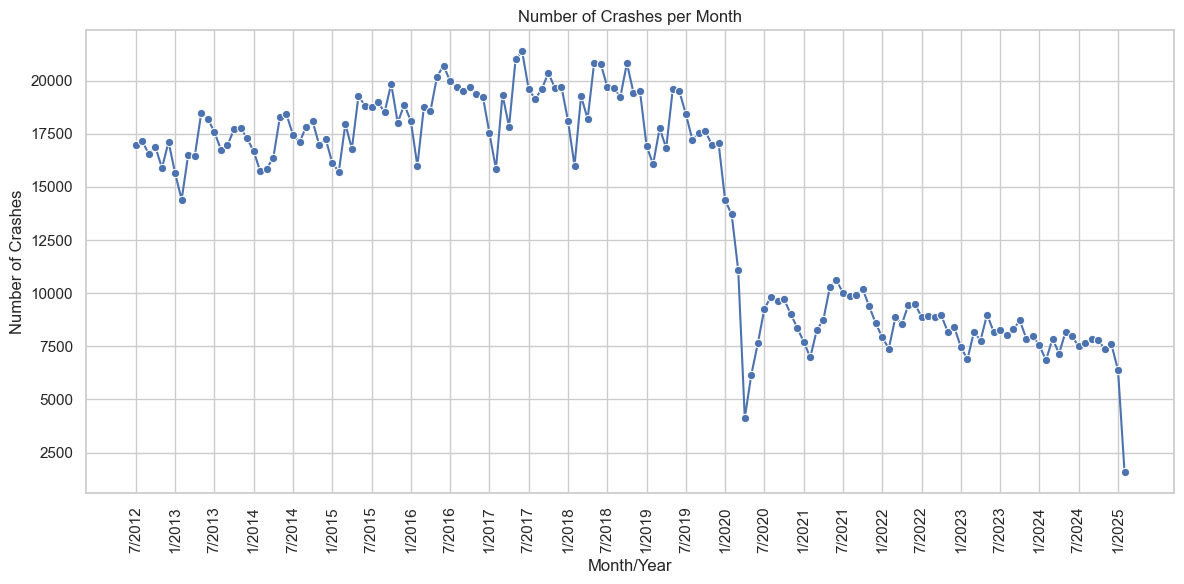

In [9]:
#Print the MOST POPULAR CRASH DATE and number of crashes on that date
most_popular_date = df_dates['CRASH DATE'].mode()[0]
most_popular_date_count = df_dates['CRASH DATE'].value_counts().max()
print(f"Most popular crash date: {most_popular_date} with {most_popular_date_count} crashes.")

#Plot the number of crashes per month (so aggregate by month)
df_dates['CRASH MONTH'] = df_dates['CRASH DATE'].dt.month
df_dates['CRASH YEAR'] = df_dates['CRASH DATE'].dt.year
df_dates['CRASH MONTH YEAR'] = df_dates['CRASH MONTH'].astype(str) + '/' + df_dates['CRASH YEAR'].astype(str)

#Group by month and year
monthly_crashes = df_dates.groupby(['CRASH MONTH', 'CRASH YEAR']).size().reset_index(name='COUNT')
monthly_crashes['CRASH MONTH YEAR'] = monthly_crashes['CRASH MONTH'].astype(str) + '/' + monthly_crashes['CRASH YEAR'].astype(str)
monthly_crashes = monthly_crashes.sort_values(by=['CRASH YEAR', 'CRASH MONTH'])

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_crashes, x='CRASH MONTH YEAR', y='COUNT', marker='o')

# Set x-axis ticks to avoid overcrowding
xticks = monthly_crashes['CRASH MONTH YEAR'][::6]  # Show every 6th month
plt.xticks(ticks=xticks, rotation=90)

plt.title('Number of Crashes per Month')
plt.xlabel('Month/Year')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()


Conclusion: COVID made the number of crashes shoot down drastically. It's been down ever since

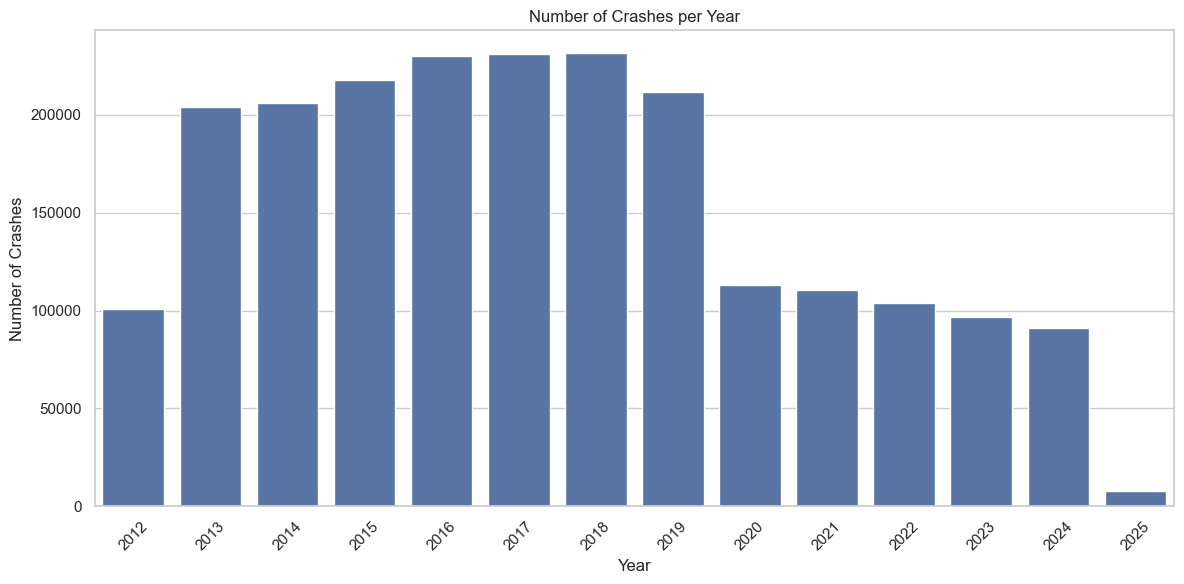

In [10]:
#Do the same thing but by year instead

#Group by year
yearly_crashes = df_dates.groupby(['CRASH YEAR']).size().reset_index(name='COUNT')
yearly_crashes = yearly_crashes.sort_values(by=['CRASH YEAR'])
#Plot the number of crashes per year
plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_crashes, x='CRASH YEAR', y='COUNT')
plt.xticks(rotation=45)
plt.title('Number of Crashes per Year')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()


Conclusion: The number of crashes changed since COVID started in 2020. The trend has continued ever since (at least, less were recorded in this dataset)

# Crash Types

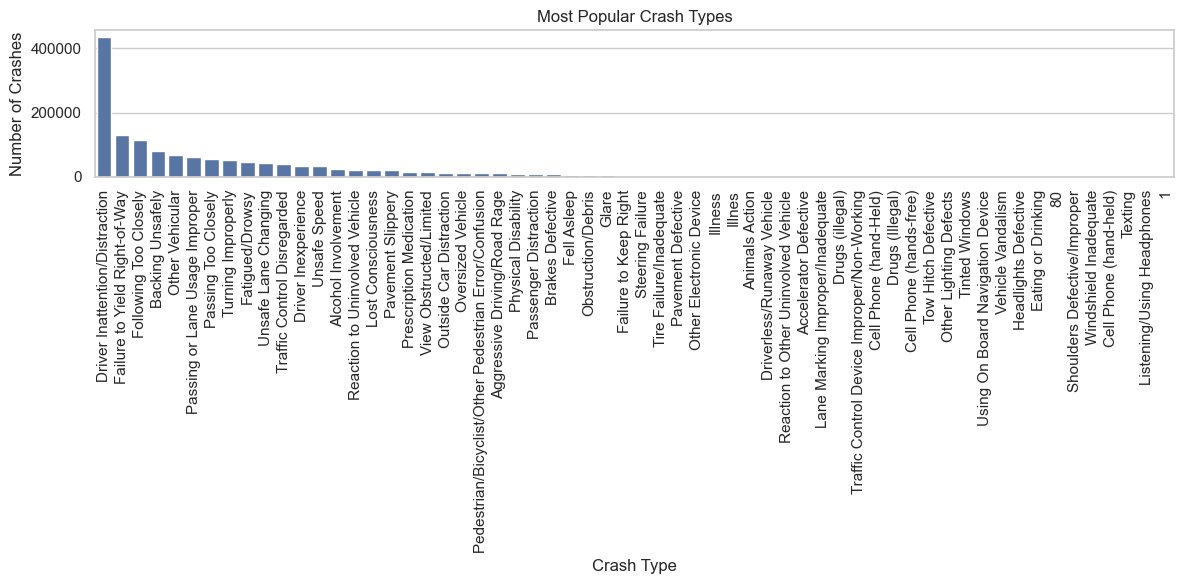

In [11]:
#Plot the most popular crash types
#Group by crash type, ignore "Unspecified"
crash_types = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().reset_index()
crash_types.columns = ['CRASH TYPE', 'COUNT']
crash_types = crash_types[~crash_types['CRASH TYPE'].isin(['Unspecified'])]
crash_types = crash_types.sort_values(by=['COUNT'], ascending=False)
#Plot the most popular crash types
plt.figure(figsize=(12, 6))
sns.barplot(data=crash_types, x='CRASH TYPE', y='COUNT')
plt.xticks(rotation=90)
plt.title('Most Popular Crash Types')
plt.xlabel('Crash Type')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()

In [12]:
#Instead of plotting, just sort the crash types by count and print the top 10

crash_types = crash_types.sort_values(by=['COUNT'], ascending=False)
print(crash_types.head(10))

                        CRASH TYPE   COUNT
1   Driver Inattention/Distraction  434676
2    Failure to Yield Right-of-Way  128656
3            Following Too Closely  115575
4                 Backing Unsafely   79083
5                  Other Vehicular   66919
6   Passing or Lane Usage Improper   61111
7              Passing Too Closely   54317
8               Turning Improperly   53087
9                  Fatigued/Drowsy   47475
10            Unsafe Lane Changing   42366


Conclusion: Pay attention to the roads!

In [13]:
df_crashes = df_dates[df_dates['CRASH DATE'].notnull()]
#remove unspecified from the crash types
df_crashes = df_crashes[~df_crashes['CONTRIBUTING FACTOR VEHICLE 1'].isin(['Unspecified'])]

C:\Users\ryana\AppData\Local\Temp\ipykernel_13084\607588627.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_crash_day_types = crash_day_types.groupby('CRASH DAY OF WEEK').apply(lambda x: x.nlargest(3, 'COUNT')).reset_index(drop=True)


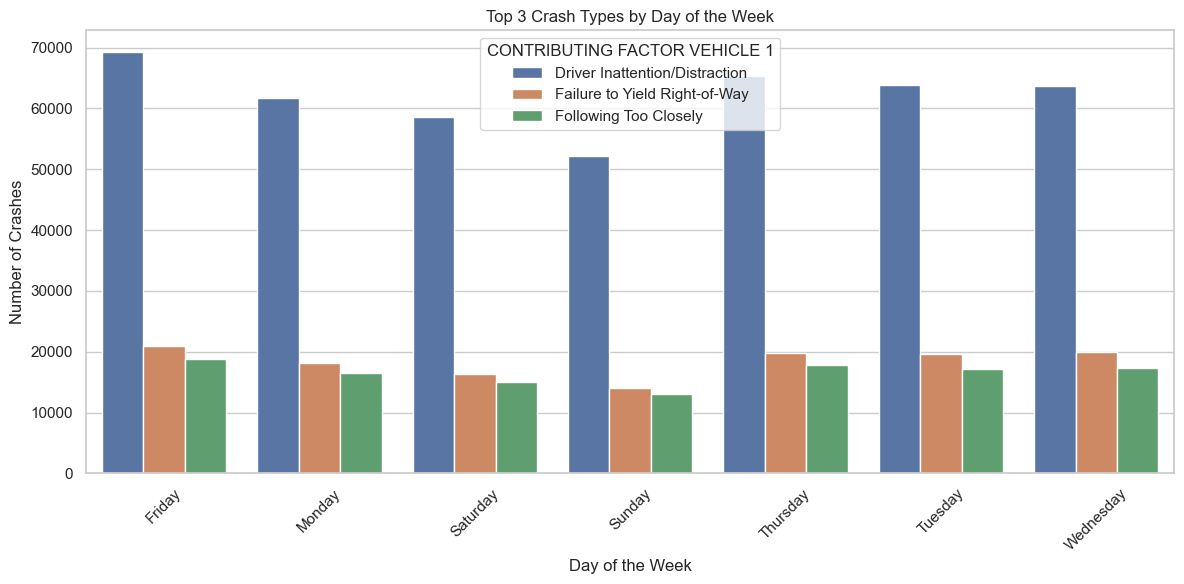

In [14]:
# Let's get the most popular crash type by the day of the week
# First, we need to extract the day of the week from the crash date

#Remove all unspecified crash types

df_crashes['CRASH DAY OF WEEK'] = df_crashes['CRASH DATE'].dt.day_name()
# Now, let's group by day of the week and crash type
crash_day_types = df_crashes.groupby(['CRASH DAY OF WEEK', 'CONTRIBUTING FACTOR VEHICLE 1']).size().reset_index(name='COUNT')
# Now, let's find the 3 most popular crash types for each day of the week
top_crash_day_types = crash_day_types.groupby('CRASH DAY OF WEEK').apply(lambda x: x.nlargest(3, 'COUNT')).reset_index(drop=True)
# Sort by day of the week

top_crash_day_types = top_crash_day_types.sort_values(by=['CRASH DAY OF WEEK', 'COUNT'], ascending=[True, False])
# Plot the top 3 crash types for each day of the week
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=top_crash_day_types, x='CRASH DAY OF WEEK', y='COUNT', hue='CONTRIBUTING FACTOR VEHICLE 1')
plt.xticks(rotation=45)
plt.title('Top 3 Crash Types by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()

Conclusion: The most common crash type does not appear to change significantly by day of the week.

### Database limitation: Unable to find the crash hour for the crashes -- they all seem to be 0

    CRASH HOUR   CONTRIBUTING FACTOR VEHICLE 1   COUNT
11           0  Driver Inattention/Distraction  434676


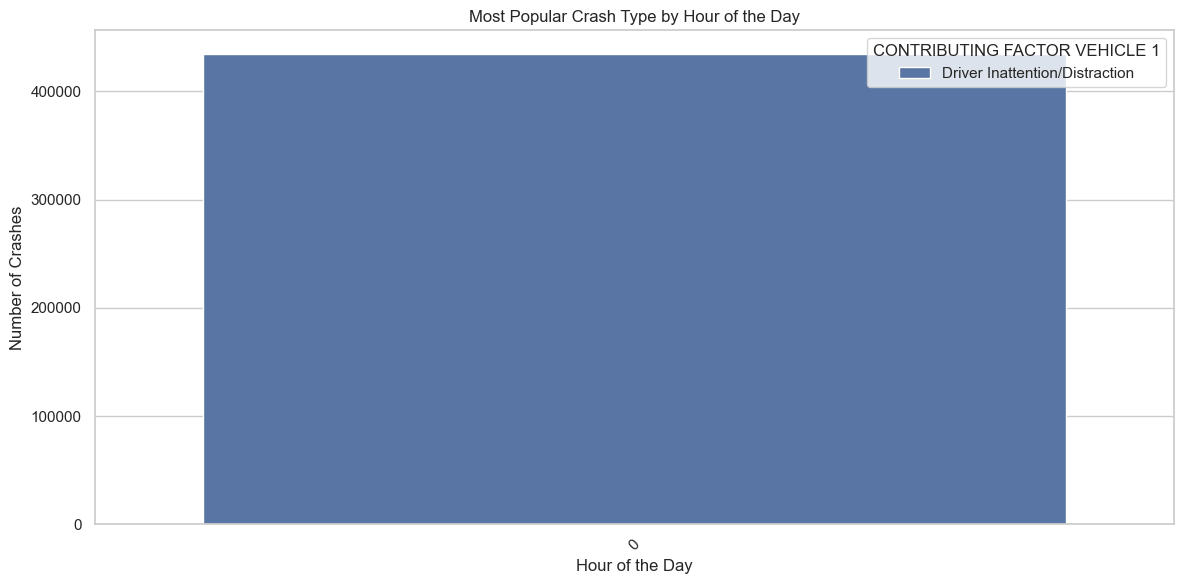

In [15]:
# DO NOT USE THIS TABLE -- THSI IS JUST TO SHOW THAT IT DOESN'T WORK FOR SOME REASON

# First, we need to extract the hour of the day from the crash date
df_crashes['CRASH HOUR'] = df_crashes['CRASH DATE'].dt.hour
# Now, let's group by hour of the day and crash type
crash_hour_types = df_crashes.groupby(['CRASH HOUR', 'CONTRIBUTING FACTOR VEHICLE 1']).size().reset_index(name='COUNT')
# Now, let's find the most popular crash type for each hour of the day
most_popular_crash_hour_types = crash_hour_types.loc[crash_hour_types.groupby('CRASH HOUR')['COUNT'].idxmax()]
# Sort by hour of the day
most_popular_crash_hour_types = most_popular_crash_hour_types.sort_values(by=['CRASH HOUR'])
# Print the most popular crash type for each hour of the day
print(most_popular_crash_hour_types)
# Plot the most popular crash type for each hour of the day
plt.figure(figsize=(12, 6))
sns.barplot(data=most_popular_crash_hour_types, x='CRASH HOUR', y='COUNT', hue='CONTRIBUTING FACTOR VEHICLE 1')
plt.xticks(rotation=45)
plt.title('Most Popular Crash Type by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()

Conclusion: Don't use this graph. It's not helpful.

### But we can get the number of crashes by hour and day of the week

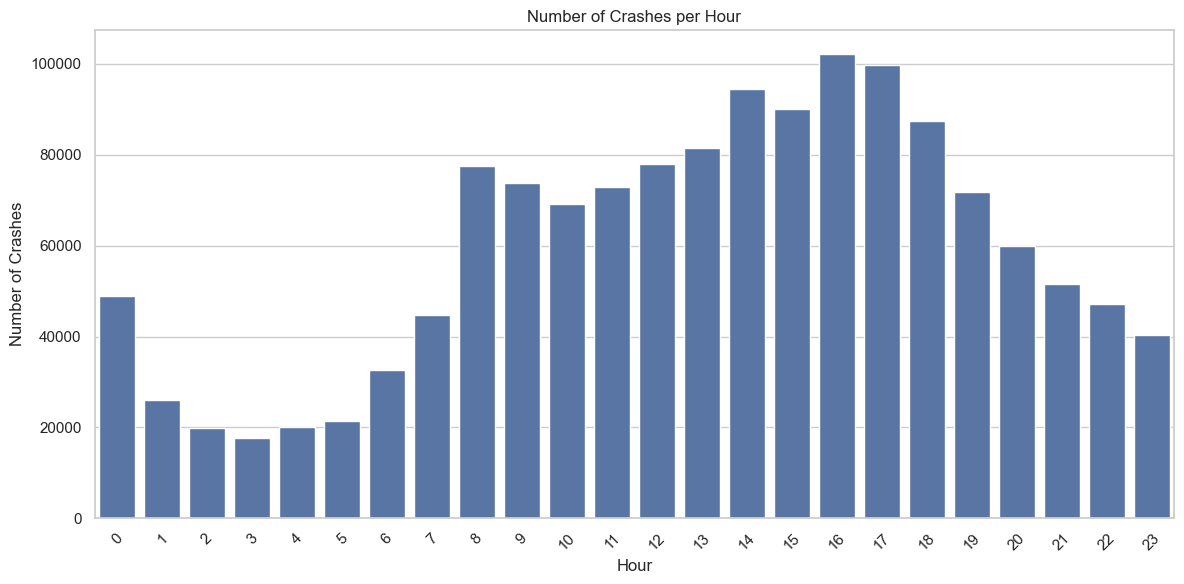

In [16]:
#Plot crashes over the time of day

#Convert CRASH TIME to datetime
df_crashes['CRASH TIME'] = pd.to_datetime(df_crashes['CRASH TIME'], format='%H:%M', errors='coerce')
#Filter out any rows that don't have a crash time
df_crashes = df_crashes.dropna(subset=['CRASH TIME'])
#Extract hour from crash time
df_crashes['CRASH HOUR'] = df_crashes['CRASH TIME'].dt.hour
#Group by hour
hourly_crashes = df_crashes.groupby(['CRASH HOUR']).size().reset_index(name='COUNT')
hourly_crashes = hourly_crashes.sort_values(by=['CRASH HOUR'])
#Plot the number of crashes per hour
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_crashes, x='CRASH HOUR', y='COUNT')
plt.xticks(rotation=45)
plt.title('Number of Crashes per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()

Conclusion: The most "dangerous" times are 4PM, 5PM, and 2PM. The least dangerous times are 2AM, 3AM, and 4AM. Hopefully this is a shock to no one.

In [17]:
hourly_crashes

,CRASH HOUR,COUNT
0,0,49010
1,1,25995
2,2,19868
3,3,17595
4,4,20016
5,5,21332
6,6,32691
7,7,44729
8,8,77449
9,9,73740


# T-tests for Crash and Dates

In [18]:
# Does the time of day affect the number of crashes -- do a t-test to see if there is a significant difference between the number of crashes during the day and night
from scipy.stats import ttest_ind
# Define day and night hours

#Define day as 6 AM to 6 PM, night as 6 PM to 6 AM
day_hours = hourly_crashes[(hourly_crashes['CRASH HOUR'] >= 6) & (hourly_crashes['CRASH HOUR'] < 18)]
night_hours = hourly_crashes[(hourly_crashes['CRASH HOUR'] < 6) | (hourly_crashes['CRASH HOUR'] >= 18)]

# Perform t-test -- using a t test because we do not know the population standard deviation (well, we could consider the population to be the entire dataset, but we are not sure if it is normally distributed)
t_stat, p_value = ttest_ind(day_hours['COUNT'], night_hours['COUNT'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")
# If p-value < 0.05, there is a significant difference
if p_value < 0.05:
    print("There is a significant difference between the number of crashes during the day and night.")
else:
    print("There is no significant difference between the number of crashes during the day and night.")

print("More crashes during the day" if day_hours['COUNT'].sum() > night_hours['COUNT'].sum() else "More crashes during the night")

T-statistic: 3.7981778508615336, P-value: 0.0009854346950314173
There is a significant difference between the number of crashes during the day and night.
More crashes during the day


Conclusion: **Statistically significantly** many more crashes during the day than at night

Chi-squared statistic: 42.000000000000014, P-value: 0.226962832847802
There is no significant difference between the number of crashes by day of the week.


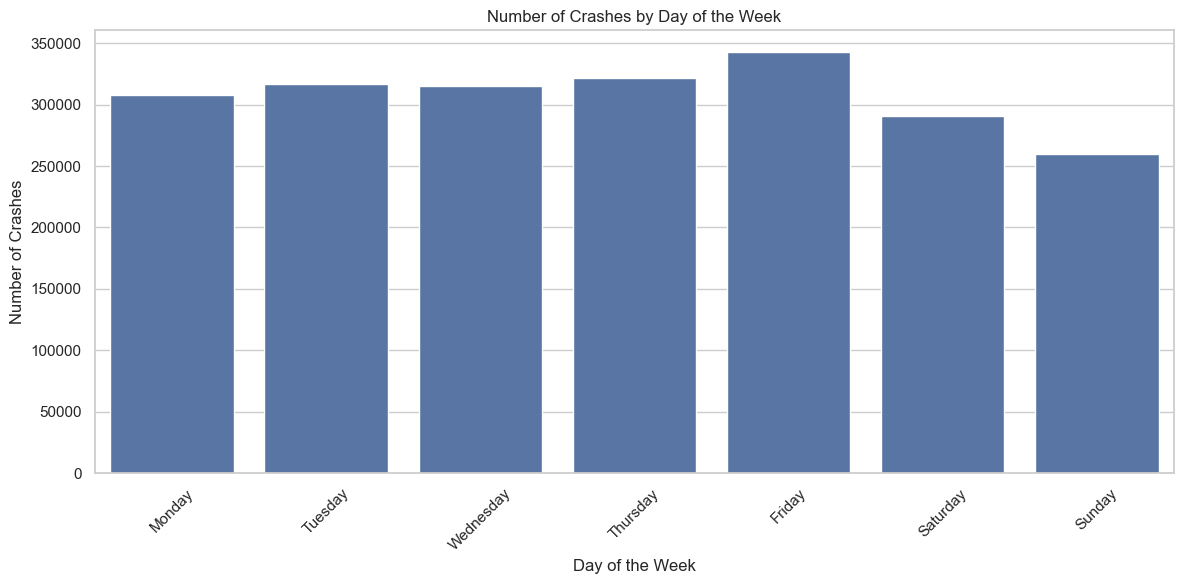

In [19]:
# Do a chi-squared test to see if there is a significant difference between the number of crashes by day of the week

from scipy.stats import chi2_contingency
# Extract day of the week from crash date
df['CRASH DAY OF WEEK'] = df['CRASH DATE'].dt.day_name()
# Group by day of the week
day_of_week_crashes = df.groupby(['CRASH DAY OF WEEK']).size().reset_index(name='COUNT')
# Reorder the days of the week

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_crashes['CRASH DAY OF WEEK'] = pd.Categorical(day_of_week_crashes['CRASH DAY OF WEEK'], categories=days_of_week, ordered=True)
day_of_week_crashes = day_of_week_crashes.sort_values(by=['CRASH DAY OF WEEK'])

# Create a contingency table
contingency_table = pd.crosstab(day_of_week_crashes['CRASH DAY OF WEEK'], day_of_week_crashes['COUNT'])
# Perform chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared statistic: {chi2_stat}, P-value: {p_value}")
# If p-value < 0.05, there is a significant difference
if p_value < 0.05:
    print("There is a significant difference between the number of crashes by day of the week.")
else:
    print("There is no significant difference between the number of crashes by day of the week.")

# Plot the number of crashes by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(data=day_of_week_crashes, x='CRASH DAY OF WEEK', y='COUNT')
plt.xticks(rotation=45)
plt.title('Number of Crashes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crashes')
plt.tight_layout()
plt.show()

Conclusion: **No Statistical Significance** between number of crashes and days of the week.

### Fataliy Plots

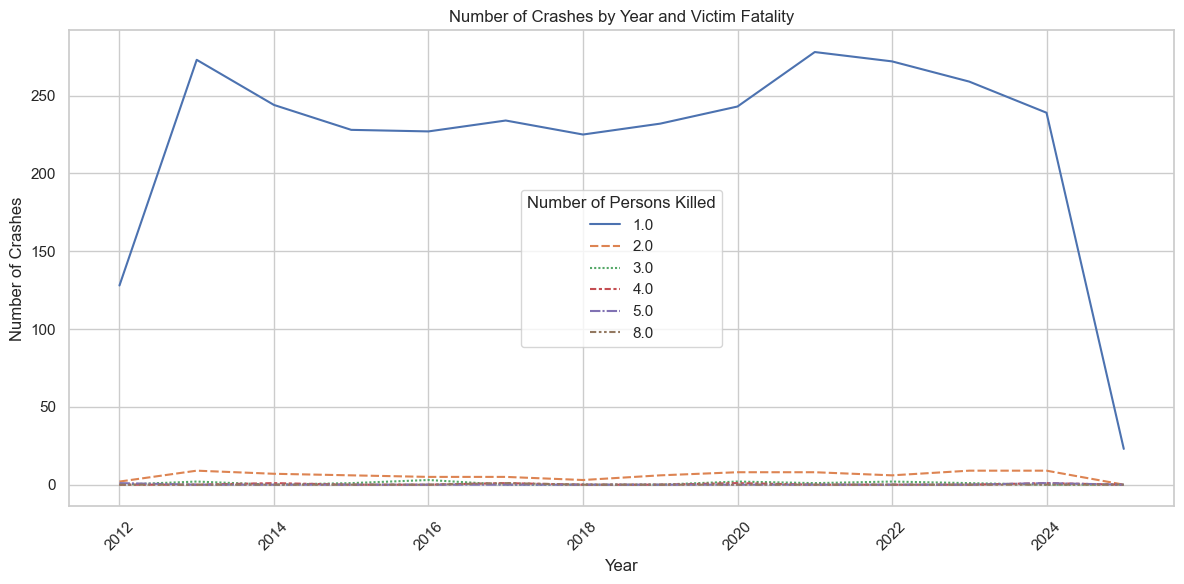

In [23]:
# Compare victim fatality over the years

victim_fatality_year = df.copy()
victim_fatality_year["CRASH YEAR"] = pd.to_datetime(victim_fatality_year["CRASH DATE"]).dt.year
#Remove the points where there are no fatalities
victim_fatality_year = victim_fatality_year[victim_fatality_year['NUMBER OF PERSONS KILLED'] > 0]
# Group by year and victim fatality
victim_fatality_year = victim_fatality_year.groupby(['CRASH YEAR', 'NUMBER OF PERSONS KILLED']).size().reset_index(name='COUNT')
# Create a pivot table
victim_fatality_year_pivot = victim_fatality_year.pivot(index='CRASH YEAR', columns='NUMBER OF PERSONS KILLED', values='COUNT')
# Fill NaN values with 0
victim_fatality_year_pivot = victim_fatality_year_pivot.fillna(0)
# Plot the number of crashes by year and victim fatality
plt.figure(figsize=(12, 6))
sns.lineplot(data=victim_fatality_year_pivot)
plt.xticks(rotation=45)
plt.title('Number of Crashes by Year and Victim Fatality')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.legend(title='Number of Persons Killed')
plt.tight_layout()
plt.show()

Conclusion: The number of fatalities in crashes dipped from 2014-2020 then went up. Could this be because of the introduction of self-driving vehicles?

C:\Users\ryana\AppData\Local\Temp\ipykernel_13084\189046235.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_crash_type_year = crash_type_year[crash_type_year['COUNT'] > 0].groupby('CRASH YEAR').apply(lambda x: x.nlargest(3, 'COUNT')).reset_index(drop=True)


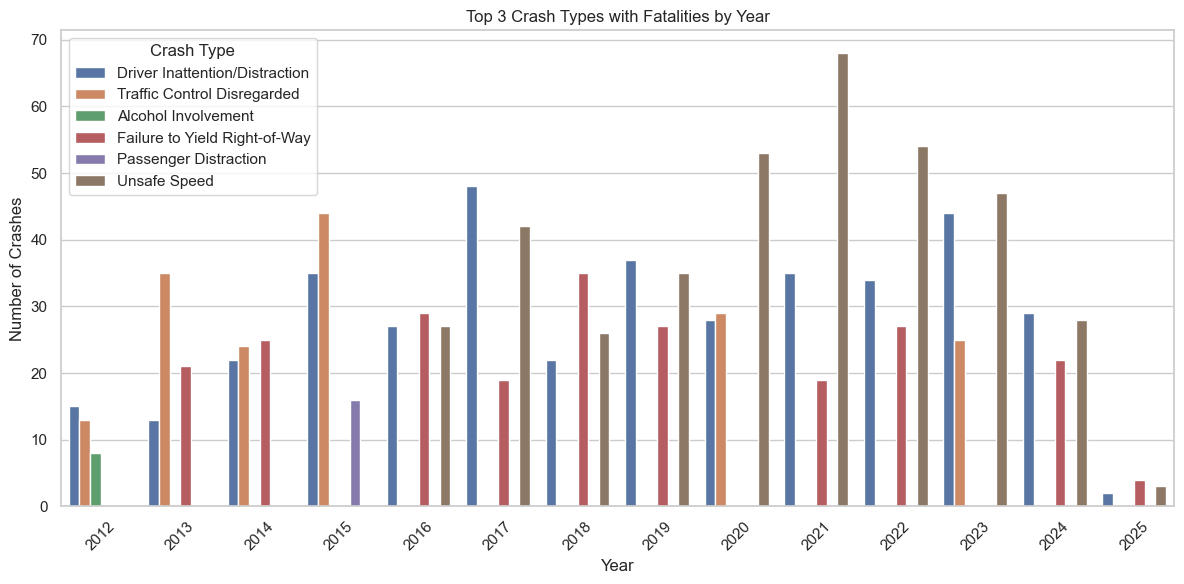

In [25]:
#Let's get the most popular crash type that has fatalities. Plot the top three in a triple bar graph and plot by year

#First, we need to extract the crash type from the crash date
df_crashes['CRASH TYPE'] = df_crashes['CONTRIBUTING FACTOR VEHICLE 1']
df_crashes = df_crashes[df_crashes['NUMBER OF PERSONS KILLED'] > 0]
#Now, let's group by crash type and year
crash_type_year = df_crashes.groupby(['CRASH YEAR', 'CRASH TYPE']).size().reset_index(name='COUNT')
#Now, let's find the top 3 crash types with fatalities
top_crash_type_year = crash_type_year[crash_type_year['COUNT'] > 0].groupby('CRASH YEAR').apply(lambda x: x.nlargest(3, 'COUNT')).reset_index(drop=True)
# Sort by year
top_crash_type_year = top_crash_type_year.sort_values(by=['CRASH YEAR'])
# Plot the top 3 crash types with fatalities by year
plt.figure(figsize=(12, 6))
sns.barplot(data=top_crash_type_year, x='CRASH YEAR', y='COUNT', hue='CRASH TYPE')
plt.xticks(rotation=45)
plt.title('Top 3 Crash Types with Fatalities by Year')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.legend(title='Crash Type')
plt.tight_layout()
plt.show()

Conclusion: The top 3 causes of fatalities over the years seems to fluctuate. However, the one that always seems to reign true is the Driver Inattention cause. Pay attention to the roads!